<a href="https://colab.research.google.com/github/carolsworld/FactoryIO_TSC/blob/main/FactoryIO_TSC_sktime_LSTMFCNClassifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Demonstration of using datasets generated multivariate time series data from Factory I/O 3D simulation for developing multi-class Time Series Classification Model for *Threat Detection* using *Long Short Term Memory Fully Convolutional Network (LSTM-FCN)* in sktime (deep learning) library**

# Background

We have identified 10 different scenarios in the Factory I/O scene. It could be a normal scenarios or threat scenarios.

For each scenario, we have carried out 10 simulation runs (i.e. 10 instances). Therefore, there are tototally 100 simulation instances in the csv dataset. Each simulation run has 60 second of simulation.

During the simulation run, we used the Web API of Factory I/O to collect data. Each instance contain 119 timepoints (timepoints from value '0' to value '118'). Therefore, the number of row in the csv dataset is 119 * 100 = 11,900 rows.


The scenario (being the label (y) to be predicted) include:

*   Label #1 - 'Sensors_NormalSpeed': use potentiometer with normal conveyor speed.
*   Label #2 - 'Sensors_TooSlowOrStop':use potentiometer with conveyor speed too slow or stopped.
*   Label #3 - 'Sensors_Oscillate': use potentiometer with conveyor speed up and down illogically.
*   Label #4 - 'Sensors_WrongDirection': use potentiometer with conveyor going the reverse direction.
*   Label #5 - 'ForcedActuator_Normal': force actuator value with normal conveyor speed.
*   Label #6 - 'ForcedActuator_TooSlowOrStop': force actuator value with conveyor speed too slow or stopped.
*   Label #7 - 'ForcedActuator_TooFast': force actuator value with conveyor speed too fast.
*   Label #8 - 'ForcedActuator_ExtremelyFast': force actuator value with conveyor speed extremely fast.
*   Label #9 - 'ForcedActuator_Oscillate': force actuator value with conveyor speed up and down illogically.
*   Label #10 - 'ForcedActuator_WrongDirection': force actuator value with conveyor going the reverse direction.

To train the deep learning model to predict the scenario, not all the data captured from the Web API of Factory I/O are used. Instead, only the following features (X) are used for deep learning model training.

Multi-variables are used for model training:
*   'var_0': Potentiometer 0 (V) - the speed input affecting the conveyor speed (collected via Web API)
*   'var_1': Q_Move Conveyor - the speed of the conveyor (collected via Web API)
*   'var_2': Speed Display - the LED displaying the speed (collected via Web API)
*   'var_3': Speed Change - the change of speed comparing the previous and current timepoints, i.e. change of speed in every 0.5 second (calculated by python script during real-time simulation)
*   'var_4': Acceleration Indicator - check if the speed is accelerating, decelerating, constant or illogically speeding up or down based on past 15 seconds in the speed history (calculated by python script during real-time simulation)
*   'var_5': Actual Conveyor Status - based on the value of Q_Move Conveyor to design which category the simulation is falling into:

> Q_Move Conveyor with -5 < speed < 0: 'conveyor wrong direction'

> Q_Move Conveyor with speed == 0: 'conveyor stop'

> Q_Move Conveyor with 0 < speed <= 2.30: 'conveyor too slow'

> Q_Move Conveyor with 2.31 < speed <= 5.00: 'normal conveying speed'

> Q_Move Conveyor with 5.01 < speed <= 7.00: 'conveyor too fast'

> Q_Move Conveyor with other values: 'abnormal'



# Step 1 - Upload dataset (csv file)

In [ ]:
# Upload your csv file and check the number of rows and columns in the pandas dataframe
from google.colab import files
import io
import pandas as pd

uploaded = files.upload()

filename = next(iter(uploaded))

df = pd.read_csv(io.BytesIO(uploaded['factoryiodata.csv']))

print("The number of rows and columns in the csv file: ", df.shape)

Saving factoryiodata.csv to factoryiodata.csv
The number of rows and columns in the csv file:  (11900, 9)


100 instances with 119 timepoints for each instance, expected number of row is 11900.

In [ ]:
# Display the first few rows of the dataframe to check file format
print(df.head())

   instances  timepoints  var_0  var_1  var_2  var_3  var_4  var_5  label
0          1           0    0.0   10.0    0.0   10.0      2      6      8
1          1           1    0.0   10.0    0.0    0.0      1      6      8
2          1           2    0.0   10.0    0.0    0.0      1      6      8
3          1           3    0.0   10.0    0.0    0.0      1      6      8
4          1           4    0.0   10.0    0.0    0.0      1      6      8


There are 9 columns as follows.
*   'instance' is instance identifier. There are 100 instance in this dataset.
*   'timepoints' is time series index for each instance. Every instance has 119 timepoints (from value '0' to value '118').
*   'var_0' to ''var_5' are the raw data to learn
*   'label' contains the labels of the instance


# Step 2 - Dataset preprocessing

In [ ]:
import numpy as np

# Set the index for multi-indexing
df = df.set_index(['instances', 'timepoints'])

# Sort the dataframe if not already sorted
df.sort_index(inplace=True)

In [ ]:
# Calculate the number of instances and timepoints
num_instances = df.index.get_level_values(0).nunique()
num_timepoints = df.index.get_level_values(1).nunique()

In [ ]:
print("Number of instances:", num_instances)
print("Number of timepoints:", num_timepoints)

Number of instances: 100
Number of timepoints: 119


In [ ]:
# Drop the 'label' column to get the features
X_features = df.drop(columns='label')

In [ ]:
X_features

var_0  var_1  var_2  var_3  var_4  var_5
instances timepoints                                          
1         0             0.0   10.0    0.0   10.0      2      6
          1             0.0   10.0    0.0    0.0      1      6
          2             0.0   10.0    0.0    0.0      1      6
          3             0.0   10.0    0.0    0.0      1      6
          4             0.0   10.0    0.0    0.0      1      6
...                     ...    ...    ...    ...    ...    ...
100       114          -5.0   -5.0   -5.0    0.0      1      6
          115          -5.0   -5.0   -5.0    0.0      1      6
          116          -5.0   -5.0   -5.0    0.0      1      6
          117          -5.0   -5.0   -5.0    0.0      1      6
          118          -5.0   -5.0   -5.0    0.0      1      6

[11900 rows x 6 columns]

In [ ]:
# Print the shapes
print("Shape before reshaping:", X_features.shape)
print("Total expected size:", num_instances * 6 * num_timepoints)

Shape before reshaping: (11900, 6)
Total expected size: 71400


In [ ]:
# Split the data into features (X) and labels (y):
# For this demonstration, there are 6 variables from var_0 to var_5.
X = df.drop(columns='label').to_numpy().reshape(-1, 6, df.index.levels[1].size)
y = df['label'].to_numpy()

In [ ]:
# Ensure labels are unique per instance and not per time point
# Reshape features (X) into a 3D numpy array
_, idx = np.unique(df.index.get_level_values(0), return_index=True)
y = y[idx]

In [ ]:
X

array([[[ 0.  , 10.  ,  0.  , ...,  0.  ,  0.  ,  1.  ],
        [ 6.  ,  0.  , 10.  , ..., 10.  ,  0.  ,  0.  ],
        [ 1.  ,  6.  ,  0.  , ...,  0.  , 10.  ,  0.  ],
        [ 0.  ,  1.  ,  6.  , ...,  6.  ,  0.  , 10.  ],
        [ 0.  ,  0.  ,  1.  , ...,  1.  ,  6.  ,  0.  ],
        [10.  ,  0.  ,  0.  , ...,  0.  ,  1.  ,  6.  ]],

       [[ 0.  ,  7.19,  0.  , ...,  0.  ,  0.  ,  1.  ],
        [ 6.  ,  0.  ,  7.19, ...,  7.19,  0.  ,  0.  ],
        [ 1.  ,  6.  ,  0.  , ...,  0.  ,  7.19,  0.  ],
        [ 0.  ,  1.  ,  6.  , ...,  6.  ,  0.  ,  7.19],
        [ 0.  ,  0.  ,  1.  , ...,  1.  ,  6.  ,  0.  ],
        [ 7.19,  0.  ,  0.  , ...,  0.  ,  1.  ,  6.  ]],

       [[ 0.  ,  7.5 ,  0.  , ...,  0.  ,  0.  ,  1.  ],
        [ 6.  ,  0.  ,  7.5 , ...,  7.5 ,  0.  ,  0.  ],
        [ 1.  ,  6.  ,  0.  , ...,  0.  ,  7.5 ,  0.  ],
        [ 0.  ,  1.  ,  6.  , ...,  6.  ,  0.  ,  7.5 ],
        [ 0.  ,  0.  ,  1.  , ...,  1.  ,  6.  ,  0.  ],
        [ 7.5 ,  0.  ,  0. 

In [ ]:
X.shape

(100, 6, 119)

X is 3D array and should have the shape [number of samples, number of variables, sequence length].

Each of the 100 instances is a 2D array of 6 variables over 119 timepoints

In [ ]:
y

array([ 8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  5,  5,  5,  5,  5,  5,  5,
        5,  5,  5,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  7,  7,  7,  7,
        7,  7,  7,  7,  7,  7,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6, 10,
       10, 10, 10, 10, 10, 10, 10, 10, 10,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  2,  2,  2,  2,  2,
        2,  2,  2,  2,  2,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4])

In [ ]:
y.shape

(100,)

y is 1D numpy array with the shape [number of samples].

In [ ]:
# Split the data into a training set and a test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42, stratify=y)


In [ ]:
X_train

array([[[ 3.32,  3.32,  3.32, ...,  3.32,  0.  ,  1.  ],
        [ 1.  ,  3.32,  3.32, ...,  3.32,  3.32,  0.  ],
        [ 1.  ,  1.  ,  3.32, ...,  3.32,  3.32,  3.32],
        [ 0.  ,  1.  ,  1.  , ...,  1.  ,  3.32,  3.32],
        [ 3.32,  0.  ,  1.  , ...,  1.  ,  1.  ,  3.32],
        [ 3.32,  3.32,  0.  , ...,  0.  ,  1.  ,  1.  ]],

       [[ 3.22,  3.22,  3.22, ...,  3.22,  0.  ,  1.  ],
        [ 1.  ,  3.22,  3.22, ...,  3.22,  3.22,  0.  ],
        [ 1.  ,  1.  ,  3.22, ...,  3.22,  3.22,  3.22],
        [ 0.  ,  1.  ,  1.  , ...,  1.  ,  3.22,  3.22],
        [ 3.22,  0.  ,  1.  , ...,  1.  ,  1.  ,  3.22],
        [ 3.22,  3.22,  0.  , ...,  0.  ,  1.  ,  1.  ]],

       [[ 0.  ,  7.19,  0.  , ...,  0.  ,  0.  ,  1.  ],
        [ 6.  ,  0.  ,  7.19, ...,  7.19,  0.  ,  0.  ],
        [ 1.  ,  6.  ,  0.  , ...,  0.  ,  7.19,  0.  ],
        [ 0.  ,  1.  ,  6.  , ...,  6.  ,  0.  ,  7.19],
        [ 0.  ,  0.  ,  1.  , ...,  1.  ,  6.  ,  0.  ],
        [ 7.19,  0.  ,  0. 

In [ ]:
X_test

array([[[ 0.  ,  6.56,  0.  , ...,  0.  ,  0.  ,  1.  ],
        [ 2.  ,  0.  ,  6.56, ...,  6.56,  0.  ,  0.  ],
        [ 1.  ,  2.  ,  0.  , ...,  0.  ,  6.56,  0.  ],
        [ 0.  ,  1.  ,  2.  , ...,  2.  ,  0.  ,  6.56],
        [ 0.  ,  0.  ,  1.  , ...,  1.  ,  2.  ,  0.  ],
        [ 6.56,  0.  ,  0.  , ...,  0.  ,  1.  ,  2.  ]],

       [[ 0.  ,  0.  ,  0.  , ...,  0.  ,  0.  ,  1.  ],
        [ 1.  ,  0.  ,  2.19, ...,  5.62,  0.  ,  0.  ],
        [ 4.  ,  2.  ,  0.  , ...,  0.  ,  7.81,  0.  ],
        [ 0.  ,  4.  ,  6.  , ...,  6.  ,  0.  ,  7.5 ],
        [ 0.  ,  0.  ,  4.  , ...,  4.  ,  6.  ,  0.  ],
        [ 7.19,  0.  ,  0.  , ...,  0.  ,  4.  ,  3.  ]],

       [[ 0.  ,  3.12,  0.  , ...,  0.  ,  0.  ,  1.  ],
        [ 1.  ,  0.  ,  3.12, ...,  3.12,  0.  ,  0.  ],
        [ 1.  ,  1.  ,  0.  , ...,  0.  ,  3.12,  0.  ],
        [ 0.  ,  1.  ,  1.  , ...,  1.  ,  0.  ,  3.12],
        [ 0.  ,  0.  ,  1.  , ...,  1.  ,  1.  ,  0.  ],
        [ 3.12,  0.  ,  0. 

In [ ]:
y_train

array([ 1,  1,  8,  3,  6,  3,  8,  3,  7, 10,  1,  6,  3,  9,  2,  6,  2,
        3,  5,  6,  7, 10,  9,  5, 10,  2, 10,  7,  5,  9,  1,  4,  4,  8,
        4,  7,  5,  2,  8,  9, 10,  4, 10,  6,  6,  1,  5,  7,  5,  8,  3,
        8,  2,  9,  2,  7,  9, 10,  2,  1,  4,  1,  7,  3,  5,  6,  9,  4,
        4,  8])

In [ ]:
y_test

array([ 7,  9,  5,  3,  2,  6,  9, 10,  6,  1,  8,  2,  5, 10,  3,  6,  1,
       10,  4,  8,  4,  2,  7,  5,  4,  1,  8,  7,  9,  3])

# Step 3 - Train the model

In [ ]:
# Install the sktime library
!pip install sktime
import sktime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.9/21.9 MB 35.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.8/128.8 kB 13.9 MB/s eta 0:00:00


In [ ]:
# Check in memory type is correct for label y
from sktime.datatypes import check_is_mtype
check_is_mtype(y, mtype="np.ndarray", return_metadata=True)

(True,
 None,
 {'is_empty': False,
  'is_univariate': True,
  'n_features': 1,
  'feature_names': [0],
  'is_equally_spaced': True,
  'has_nans': False,
  'mtype': 'np.ndarray',
  'scitype': 'Series'})

In [ ]:
import numpy as np
import seaborn as sns

from sktime.classification.deep_learning.lstmfcn import LSTMFCNClassifier

sns.set_style("whitegrid")

In [ ]:
# Initialize the LSTMFCNClassifier
classifier = LSTMFCNClassifier()

In [ ]:
# Fit the classifier on the training data
classifier.fit(X_train, y_train)

LSTMFCNClassifier(callbacks=[])

# Step 4 - Prediction and Performance Analysis

In [ ]:
# Predict the labels for the test set
y_pred = classifier.predict(X_test)

1/1 [==============================] - 1s 751ms/step


In [ ]:
# Calculate accuracy
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.9


The scenario (being the label (y) to be predicted) include:

*   Label #1 - 'Sensors_NormalSpeed': use potentiometer with normal conveyor speed.
*   Label #2 - 'Sensors_TooSlowOrStop':use potentiometer with conveyor speed too slow or stopped.
*   Label #3 - 'Sensors_Oscillate': use potentiometer with conveyor speed up and down illogically.
*   Label #4 - 'Sensors_WrongDirection': use potentiometer with conveyor going the reverse direction.
*   Label #5 - 'ForcedActuator_Normal': force actuator value with normal conveyor speed.
*   Label #6 - 'ForcedActuator_TooSlowOrStop': force actuator value with conveyor speed too slow or stopped.
*   Label #7 - 'ForcedActuator_TooFast': force actuator value with conveyor speed too fast.
*   Label #8 - 'ForcedActuator_ExtremelyFast': force actuator value with conveyor speed extremely fast.
*   Label #9 - 'ForcedActuator_Oscillate': force actuator value with conveyor speed up and down illogically.
*   Label #10 - 'ForcedActuator_WrongDirection': force actuator value with conveyor going the reverse direction.

In [ ]:
# Check classification_report
from sklearn.metrics import classification_report

report = classification_report(y_test, y_pred, output_dict=True)

print(classification_report(y_test, y_pred))



              precision    recall  f1-score   support

           1       1.00      1.00      1.00         3
           2       0.75      1.00      0.86         3
           3       0.75      1.00      0.86         3
           4       1.00      1.00      1.00         3
           5       1.00      1.00      1.00         3
           6       0.67      0.67      0.67         3
           7       1.00      1.00      1.00         3
           8       1.00      1.00      1.00         3
           9       1.00      0.33      0.50         3
          10       1.00      1.00      1.00         3

    accuracy                           0.90        30
   macro avg       0.92      0.90      0.89        30
weighted avg       0.92      0.90      0.89        30



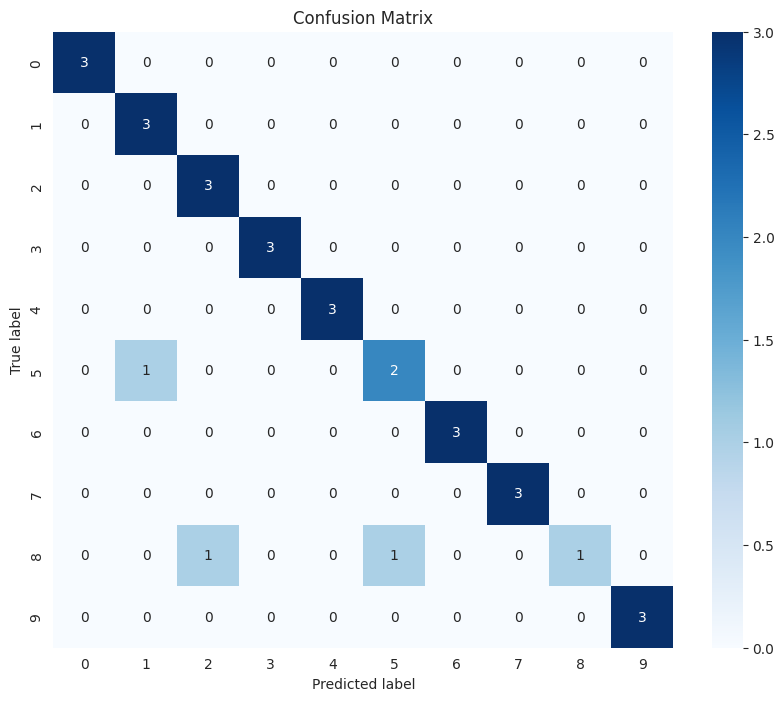

In [ ]:
# Check confusion matrix
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap=plt.cm.Blues)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.show()

# Step 5 - Save and load model

In [ ]:
# Save model using pickle
import pickle

model_filename = '/content/FactoryIO_LSTMFCN.pkl'

with open(model_filename, 'wb') as file:
    pickle.dump(classifier, file)

Reminder: download the model from Google Colab file directory.

In [ ]:
# Load the model
with open(model_filename, 'rb') as file:
    loaded_model = pickle.load(file)

The End